## Libraries

In [ ]:
import pandas as pd  
import numpy as np  
import matplotlib.pyplot as plt  
import seaborn as sns 
from sklearn.model_selection import train_test_split 
from sklearn import metrics

from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer

from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import StackingClassifier

#Load dataset

In [ ]:
from google.colab import files
uploaded = files.upload()
import io
dataset = pd.read_csv(io.BytesIO(uploaded['titanic.csv']), header=0)

Saving titanic.csv to titanic.csv


# Exploring Dataset

In [ ]:
dataset.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


## Variables Description

| Variable|Description|
|:---:|----------:|
|survival|	Survival	0 = No, 1 = Yes
|pclass	|Ticket class	1 = 1st, 2 = 2nd, 3 = 3rd
|sex	|Sex	
|Age	|Age in years	
|sibsp|	# of siblings / spouses aboard the Titanic	
|parch|	# of parents / children aboard the Titanic	
|ticket|	Ticket number	
|fare	|Passenger fare	
|cabin|	Cabin number	
|embarked|	Port of Embarkation	C = Cherbourg, Q = Queenstown, S = Southampton

## Preprocessing Data

Determine those columns with missing values

In [ ]:
dataset.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [ ]:
#Apply an imputation method
imp = SimpleImputer(strategy="most_frequent")
array_transformation=imp.fit_transform(dataset.loc[:,['Age','Cabin','Embarked']])
dataset["Age"]=array_transformation[:,0]
dataset["Cabin"]=array_transformation[:,1]
dataset["Embarked"]=array_transformation[:,2]
#Additionally transform Age column to integer column
dataset["Age"]=dataset["Age"].astype(int)
dataset.isnull().sum()

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Cabin          0
Embarked       0
dtype: int64

In [ ]:
dataset.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22,1,0,A/5 21171,7.2500,B96 B98,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26,0,0,STON/O2. 3101282,7.9250,B96 B98,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35,0,0,373450,8.0500,B96 B98,S


Transform label values

In [ ]:
#Encode label values
to_be_encoded=dataset.loc[:,['Sex','Cabin','Embarked']]

le_s = preprocessing.LabelEncoder()
encoded_sex=le_s.fit_transform(to_be_encoded['Sex'])
dataset['Sex']=encoded_sex

le_c = preprocessing.LabelEncoder()
encoded_cabin=le_c.fit_transform(to_be_encoded['Cabin'])
dataset['Cabin']=encoded_cabin

le_e = preprocessing.LabelEncoder()
encoded_emb=le_c.fit_transform(to_be_encoded['Embarked'])
dataset['Embarked']=encoded_emb




In [ ]:
dataset[['Sex','Cabin','Embarked']].head()
dataset['Sex'].unique()
dataset.shape

(891, 12)

In [ ]:
dataset.corr()['Survived']

PassengerId   -0.005007
Survived       1.000000
Pclass        -0.338481
Age           -0.052883
SibSp         -0.035322
Parch          0.081629
Fare           0.257307
Name: Survived, dtype: float64

### **Does make sense a correlation between non-numerical values?**

Discussion:

In [ ]:
features_to_be_encoded=['Survived','Pclass','Sex','Embarked']
enc=OneHotEncoder()
encoded_data =enc.fit_transform(dataset[features_to_be_encoded])
encoded_data=pd.DataFrame.sparse.from_spmatrix(encoded_data)
encoded_data.columns=enc.get_feature_names(features_to_be_encoded)
encoded_data.head()

,Survived_0,Survived_1,Pclass_1,Pclass_2,Pclass_3,Sex_0,Sex_1,Embarked_0,Embarked_1,Embarked_2
0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
1,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
2,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0
3,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
4,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0


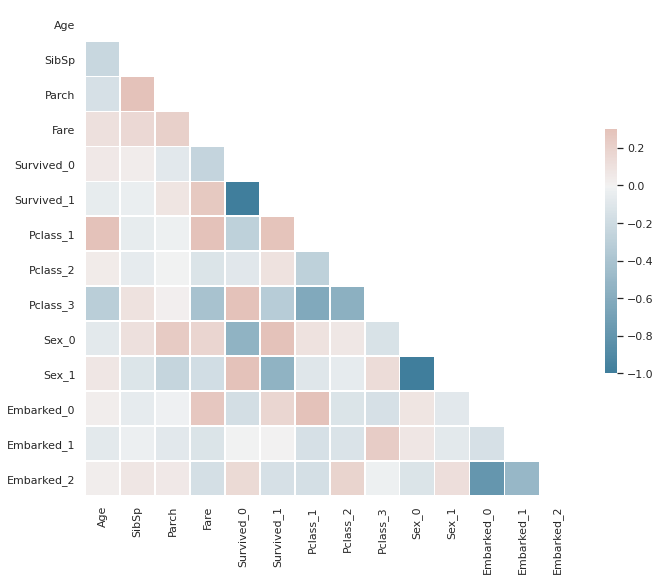

In [ ]:
numerical_features=['Age','SibSp','Parch','Fare']
final_data=pd.concat([dataset[numerical_features],encoded_data], axis=1)

correlation_matrix=final_data.corr(method="pearson") #Use only predictor variables
sns.set_theme(style="white")
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))
# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(correlation_matrix, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})


# Feature Selection

## Sort correlations

In [ ]:
my_filter=correlation_matrix['Survived_0']>=0
print(correlation_matrix.loc[my_filter, 'Survived_0'].sort_values(ascending=False))
my_filter=correlation_matrix['Survived_0']<0
print(correlation_matrix.loc[my_filter, 'Survived_0'].sort_values(ascending=True))

my_filter=correlation_matrix['Survived_1']>=0
print(correlation_matrix.loc[my_filter, 'Survived_1'].sort_values(ascending=False))
my_filter=correlation_matrix['Survived_1']<0
print(correlation_matrix.loc[my_filter, 'Survived_1'].sort_values(ascending=True))

Survived_1    1.000000
Sex_0         0.543351
Pclass_1      0.285904
Fare          0.257307
Embarked_0    0.168240
Pclass_2      0.093349
Parch         0.081629
Embarked_1    0.003650
Name: Survived_1, dtype: float64
Survived_0   -1.000000
Sex_1        -0.543351
Pclass_3     -0.322308
Embarked_2   -0.149683
Age          -0.052883
SibSp        -0.035322
Name: Survived_1, dtype: float64


## Choose the most correlated variables as predictors

In [ ]:
columns=['Sex_1','Pclass_3', 'Embarked_2','Age','SibSp','Sex_0','Pclass_1','Fare','Embarked_0']
X = final_data.loc[:,columns] #predictors
y = dataset.loc[:,'Survived'] #outcome


## Define Training and Test Datasets

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(X, y, random_state=1)
print("Training %d instances"%(x_train.shape[0]))
print("Test %d instances"%(x_test.shape[0]))

Training 668 instances
Test 223 instances


#Random Forest

In [ ]:
rf = RandomForestClassifier(max_depth=2, random_state=0)
rf.fit(x_train, y_train)
pred=rf.predict(x_test)
acc=metrics.accuracy_score(y_test, pred)
print(acc)


0.7802690582959642


In [ ]:
from sklearn.model_selection import GridSearchCV

rf = RandomForestClassifier()
parameters = {
    'n_estimators': [5, 50, 250],
    'max_depth': [2, 4, 8, 16, 32, None]
}
###############################################################################
#We user GridSearchCV to find  the best set of parameters  
###############################################################################
cv = GridSearchCV(rf, parameters, cv=5)
cv.fit(x_train, y_train)

def print_results(results):
    print('BEST PARAMS: {}\n'.format(results.best_params_))
    means = results.cv_results_['mean_test_score']
    stds = results.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, results.cv_results_['params']):
        print('{} (+/-{}) for {}'.format(round(mean, 3), round(std * 2, 3), params))
print_results(cv)

BEST PARAMS: {'max_depth': 8, 'n_estimators': 50}

0.782 (+/-0.076) for {'max_depth': 2, 'n_estimators': 5}
0.784 (+/-0.087) for {'max_depth': 2, 'n_estimators': 50}
0.78 (+/-0.08) for {'max_depth': 2, 'n_estimators': 250}
0.811 (+/-0.11) for {'max_depth': 4, 'n_estimators': 5}
0.825 (+/-0.101) for {'max_depth': 4, 'n_estimators': 50}
0.828 (+/-0.087) for {'max_depth': 4, 'n_estimators': 250}
0.823 (+/-0.027) for {'max_depth': 8, 'n_estimators': 5}
0.837 (+/-0.07) for {'max_depth': 8, 'n_estimators': 50}
0.837 (+/-0.049) for {'max_depth': 8, 'n_estimators': 250}
0.792 (+/-0.057) for {'max_depth': 16, 'n_estimators': 5}
0.823 (+/-0.062) for {'max_depth': 16, 'n_estimators': 50}
0.828 (+/-0.054) for {'max_depth': 16, 'n_estimators': 250}
0.799 (+/-0.044) for {'max_depth': 32, 'n_estimators': 5}
0.813 (+/-0.047) for {'max_depth': 32, 'n_estimators': 50}
0.819 (+/-0.062) for {'max_depth': 32, 'n_estimators': 250}
0.799 (+/-0.065) for {'max_depth': None, 'n_estimators': 5}
0.822 (+/-0.06) f

#Foundation of Ensambling Methods


## Marginal Training



In [ ]:
#Create models
model1 = DecisionTreeClassifier()
model2 = KNeighborsClassifier()
model3= GaussianNB()
#Training
model1.fit(x_train,y_train)
model2.fit(x_train,y_train)
model3.fit(x_train,y_train)

GaussianNB(priors=None, var_smoothing=1e-09)

## 0. Marginal predictions  

In [ ]:

pred1=model1.predict(x_test)
pred2=model2.predict(x_test)
pred3=model3.predict(x_test)

for i in range(0,len(x_test)):
  print([pred1[i], pred2[i], pred3[i]])
print("Marginals Accuracies")



[1, 1, 1]
[0, 0, 0]
[1, 0, 1]
[1, 1, 0]
[1, 1, 1]
[0, 0, 0]
[1, 1, 1]
[1, 0, 1]
[0, 1, 1]
[1, 0, 0]
[0, 0, 0]
[0, 0, 0]
[0, 1, 1]
[0, 0, 0]
[1, 1, 0]
[0, 1, 0]
[0, 0, 0]
[0, 0, 0]
[0, 0, 0]
[1, 1, 1]
[0, 0, 0]
[0, 0, 0]
[1, 1, 1]
[0, 0, 0]
[0, 0, 1]
[0, 0, 0]
[1, 1, 1]
[1, 1, 1]
[0, 0, 0]
[0, 1, 1]
[1, 0, 0]
[1, 1, 0]
[0, 0, 0]
[0, 0, 0]
[0, 0, 0]
[1, 0, 0]
[1, 1, 1]
[0, 0, 0]
[1, 1, 1]
[0, 0, 0]
[0, 0, 0]
[1, 1, 0]
[1, 1, 1]
[1, 0, 0]
[0, 0, 0]
[0, 0, 0]
[0, 0, 0]
[0, 0, 0]
[1, 1, 1]
[0, 0, 0]
[1, 0, 0]
[1, 0, 1]
[0, 0, 0]
[0, 0, 0]
[0, 0, 0]
[1, 0, 0]
[0, 0, 0]
[0, 1, 1]
[0, 0, 0]
[0, 0, 0]
[0, 0, 1]
[0, 0, 0]
[0, 1, 0]
[0, 0, 0]
[0, 1, 1]
[0, 0, 1]
[1, 0, 0]
[0, 1, 0]
[0, 0, 1]
[0, 0, 0]
[0, 0, 0]
[0, 0, 0]
[0, 1, 1]
[0, 0, 0]
[1, 0, 1]
[0, 0, 0]
[1, 0, 1]
[0, 0, 0]
[1, 0, 1]
[1, 1, 1]
[0, 1, 0]
[0, 0, 0]
[0, 0, 0]
[0, 0, 0]
[1, 1, 1]
[0, 0, 0]
[0, 0, 0]
[0, 0, 0]
[0, 0, 0]
[0, 0, 1]
[1, 1, 1]
[0, 0, 0]
[0, 0, 0]
[1, 1, 0]
[0, 0, 0]
[0, 0, 0]
[0, 0, 0]
[1, 0, 1]
[0, 0, 0]
[0, 0, 0]


### Visualization of predictions

DT0.7982062780269058
KN0.7488789237668162
NB0.7399103139013453


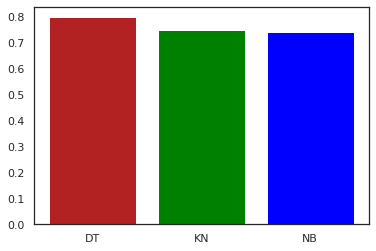

In [ ]:
#Function to visualize results
def plot_prediction(prediction, labels):
  levels = np.arange(len(labels))
  # Create bars
  plt.bar(levels, prediction, color=['firebrick', 'green', 'blue'] )
  # Create names on the x-axis
  plt.xticks(levels, labels)
  # Show graphic
  plt.show()
#Visualization
names_models=['DT','KN','NB']
predictions=[pred1, pred2, pred3]
accuracies=[]
model_index=0
for m in names_models:
  acc=metrics.accuracy_score(y_test, predictions[model_index])
  accuracies.append(acc)
  model_index+=1
  print(m+str(acc))


#Visualize Accuracy
plot_prediction(accuracies, names_models)
#print("New visitor: propensity :",classifier.predict_proba(browsing_data)[:,1] )

## 1. Max Voting Technique

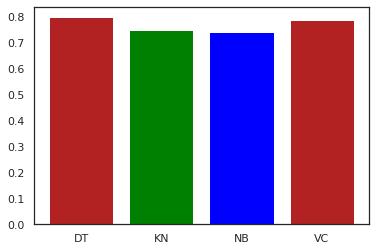

Global Accuracy:0.7892376681614349


In [ ]:
from sklearn.ensemble import VotingClassifier
model = VotingClassifier(estimators=[('dt', model1), ('kn', model2),('nb', model3)], voting='hard')
model.fit(x_train,y_train)

acc=model.score(x_test,y_test)
accuracies.append(acc)
names_models.append("VC")
plot_prediction(accuracies, names_models)
print("Global Accuracy:"+str(acc))

## 2. Average Technique
In this technique the prediction is averaged. Since usually in classification problems, the prediction is a categorical value, we have to transform such a
prediction into a real value as the probability of the classes. 

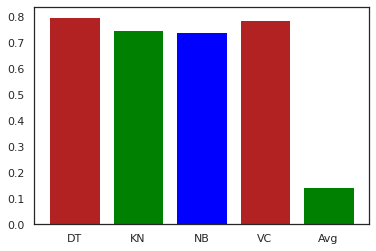

Global Accuracy:0.14349775784753363


In [ ]:
#The meth0d predict_proba is different to predict. 
#This returns the probability of the clases
pred1=model1.predict_proba(x_test) 
pred2=model2.predict_proba(x_test)
pred3=model3.predict_proba(x_test)
finalpred=[]
for i in range(0, len(pred1)):
  averages=(pred1[i,:]+pred2[i,:]+pred3[i,:])/3
  finalpred.append(np.argmax(averages)+1)

finalpred=np.array(finalpred)

acc=metrics.accuracy_score(y_test, finalpred)
accuracies.append(acc)
names_models.append("Avg")
plot_prediction(accuracies, names_models)
print("Global Accuracy:"+str(acc))


## 3. Stacking Techniques

In [ ]:
from sklearn.model_selection import StratifiedKFold 
#Encapsulted in a function
def Stacking(model,train,y,test,n_fold):
#Step 1:Define the K-folds parameters
  folds=StratifiedKFold(n_splits=n_fold,random_state=1)
#Step 2:Define arrays to storage test predictions and train prediction  
  test_pred=np.empty((0,1),float)
  train_pred=np.empty((0,1),float)
#Step 3 Split the train dataset into k-folds, train with k-1 folds and validate
#with the remain fold.  
  for train_indices,val_indices in folds.split(train,y.values):
    #Determine the training and validation datasets based on the splits
    x_train,x_val=train.iloc[train_indices],train.iloc[val_indices]
    y_train,y_val=y.iloc[train_indices],y.iloc[val_indices]
    #Train the model using training data
    model.fit(X=x_train,y=y_train)
    #Predict using validation data
    train_pred=np.append(train_pred,model.predict(x_val))
    #Predict using validation data
  test_pred=np.append(test_pred,model.predict(test))
    
  return test_pred,train_pred
  

Using stacking approach

Level 1, model 1

In [ ]:
model1 = DecisionTreeClassifier(random_state=1)
test_pred1 ,train_pred1=Stacking(model=model1,n_fold=10, train=x_train,test=x_test,y=y_train)
train_pred1=pd.DataFrame(train_pred1) #New train dataset
test_pred1=pd.DataFrame(test_pred1)   #New test  dataset
print(train_pred1.shape)
print(test_pred1.shape)

(668, 1)
(223, 1)


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


Level 1, model 2

In [ ]:
model2 = KNeighborsClassifier()
test_pred2 ,train_pred2=Stacking(model=model2,n_fold=10,train=x_train,test=x_test,y=y_train)
train_pred2=pd.DataFrame(train_pred2)
test_pred2=pd.DataFrame(test_pred2)

print(train_pred2.shape)
print(test_pred2.shape)

(668, 1)
(223, 1)


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


Level 2, metamodel

Global Accurracy:0.8026905829596412


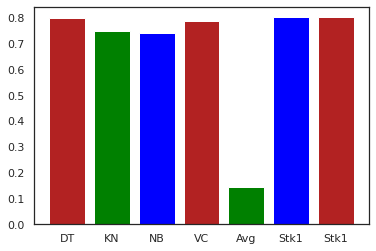

In [ ]:
from sklearn.linear_model import LogisticRegression
df_train = pd.concat([train_pred1, train_pred2], axis=1)
df_test = pd.concat([test_pred1, test_pred2], axis=1)
model3 = LogisticRegression(random_state=1)
model3.fit(df_train,y_train)
df_train.shape
y_train.shape
pd.concat([df_train.reset_index(),pd.DataFrame(y_train)], axis=1)
final_predictions=model3.predict(df_test)
print("Global Accurracy:"+str(metrics.accuracy_score(y_test, final_predictions)))
#Visualization
acc=metrics.accuracy_score(y_test, final_predictions)
accuracies.append(acc)
names_models.append("Stk1")
plot_prediction(accuracies, names_models)


## Use sklearn implementation

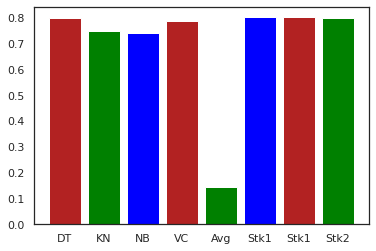

In [ ]:
estimators=[('DT',model1),('KN', model2)]
clf = StackingClassifier(estimators=estimators,cv=10, stack_method='predict',final_estimator=model3)
acc=clf.fit(x_train,y_train).score(x_test,y_test)
accuracies.append(acc)
names_models.append("Stk2")
plot_prediction(accuracies, names_models)

# Advanced Techniques
## Next Sesion (June 20)

BAGGING

In [ ]:
from sklearn.ensemble import BaggingClassifier
from sklearn import tree
model = BaggingClassifier(tree.DecisionTreeClassifier(random_state=1))
model.fit(x_train, y_train)
model.score(x_test,y_test)


0.9333333333333333

BOOSTING

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
model = AdaBoostClassifier(random_state=1)
model.fit(x_train, y_train)
model.score(x_test,y_test)


0.5555555555555556

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
model= GradientBoostingClassifier(learning_rate=0.01,random_state=1)
model.fit(x_train, y_train)
model.score(x_test,y_test)

0.9111111111111111

In [ ]:
from sklearn.ensemble import RandomForestRegressor
# Instantiate model with 1000 decision trees
model = RandomForestRegressor(n_estimators = 1000, random_state = 42)
# Train the model on training data
model.fit(x_train, y_train);
model.score(x_test,y_test)

0.9662670066889633